In [1]:
import pandas as pd
import numpy as np
from random import shuffle
% matplotlib inline

df = pd.read_csv("quickstartod1.csv",sep=",");
df1 = df[['timestep_time', 'vehicle_id', 'vehicle_x', 'vehicle_y']];

df1[1:10]

,timestep_time,vehicle_id,vehicle_x,vehicle_y
1,1,1089,1204.95,5.10
2,1,59,398.35,384.88
3,2,1089,1201.65,15.35
4,2,522,1595.05,394.90
5,2,59,398.35,373.76
6,3,1089,1201.65,25.77
7,3,522,1595.05,384.36
8,3,59,398.35,362.63
9,4,1089,1201.65,36.63


In [14]:

def vehicles_detected(sensor_data, perc):
    """
    Pick perc cars from sensor_data that can be detected by the sensors
    :param sensor_data:
    :type sensor_data: pandas DataFrame
    :param perc:
    :type perc: float from 0 to 1
    :return: cars from sensor_data that can be detected by the sensors
    :rtype: pandas DataFrame
    """
    vids = sensor_data['vehicle_id'].unique()
    sample_size = int(perc * len(vids))
    shuffle(vids)
    detected_vehicles = vids[:sample_size]
    sensor_data = sensor_data[sensor_data['vehicle_id'].isin(detected_vehicles)]
    return sensor_data, detected_vehicles

def detected_by_sensor(x, y, x0, y0, r):
    """
    Whether or not vehicule at position (x, y) can be detected by sensor at (x0, y0) with radius r
    :param x:
    :type x:
    :param y:
    :type y:
    :param x0:
    :type x0:
    :param y0:
    :type y0:
    :param r:
    :type r:
    :return:
    :rtype:
    """
    return (x - x0) ** 2 + (y - y0) ** 2 <= r ** 2

def sensor_detections(sumo_output, sensors_x, sensors_y, sensors_rad, perc=0.2):
    """
    List of the vehicles detected by sensors, with detection times (Nan if never detected)
    :param sumo_output: sumo output
    :type sumo_output: pandas DataFrame
    :param sensors_x: x coordinates of sensors
    :type sensors_x: List
    :param sensors_y: y coordinates of sensors
    :type sensors_y: List
    :param sensors_rad: radiuses of sensors
    :type sensors_rad: List
    :param perc: percentage of vehicles that can be detected
    :type perc: float
    :return: vehicles detected by sensors, with detection times
    :rtype: pandas DataFrame
    """
    # Data the sensor gets
    sensor_data = sumo_output[['timestep_time', 'vehicle_id', 'vehicle_x', 'vehicle_y']]
    sensor_data, detected_vehicles = vehicles_detected(sensor_data, perc)

    nb_sensors = len(sensors_x)
    for i in range(nb_sensors):
        sensor_x, sensor_y, sensor_rad = sensors_x[i], sensors_y[i], sensors_rad[i]
        sensor_data['detected_sensor_{}'.format(i)] = detected_by_sensor(sensor_data['vehicle_x'],
                                                                         sensor_data['vehicle_y'],
                                                                         sensor_x,
                                                                         sensor_y,
                                                                         sensor_rad)
    sensor_data.drop(['vehicle_x', 'vehicle_y'], inplace=True, axis=1)

    detection_times = pd.DataFrame(index=detected_vehicles)
    for i in range(nb_sensors):
        col_name = 'detected_sensor_{}'.format(i)
        detection_times[col_name] = sensor_data[sensor_data[col_name] == True].groupby(['vehicle_id'])[
            'timestep_time'].mean() #min

    detection_times['vehicle_id'] = detection_times.index

    detection_times['detected_by'] = detection_times.apply(
        lambda row: [k for k in range(nb_sensors) if (row['detected_sensor_{}'.format(k)] > 0)], axis=1)
    detection_times['nb_detections'] = detection_times['detected_by'].apply(lambda x: len(x))
    detection_times = detection_times[detection_times['nb_detections'] > 1]
    detection_times['incoming'] = detection_times.apply(lambda x: x['detected_sensor_{}'.format(x['detected_by'][0])] < x[
        'detected_sensor_{}'.format(x['detected_by'][-1])], axis=1)
    return detection_times


def distances(sensors_x, sensors_y):
    dist = []
    for i in range(len(sensors_x) - 1):
        dist.append(np.sqrt((sensors_x[i] - sensors_x[i + 1]) ** 2 + (sensors_y[i] - sensors_y[i + 1]) ** 2))
    return dist


In [69]:
n_intersections = 5
n_sensors = n_intersections
sensors_x = [400 + 200 * k - 7 for k in range(n_sensors)]
sensors_y = [150 for k in range(n_sensors)] 
sensors_rad = [100.0 for k in range(n_sensors)]

In [16]:
len(set(sumo_output['vehicle_id'])), len(set(sensor_data['vehicle_id']))

(1943, 1943)

In [70]:
sensor_data = sumo_output[['timestep_time', 'vehicle_id', 'vehicle_x', 'vehicle_y']]
sensor_data, detected_vehicles = vehicles_detected(sensor_data, 1)

nb_sensors = len(sensors_x)
for i in range(nb_sensors):
    sensor_x, sensor_y, sensor_rad = sensors_x[i], sensors_y[i], sensors_rad[i]
    sensor_data['detected_sensor_{}'.format(i)] = detected_by_sensor(sensor_data['vehicle_x'],
                                                                     sensor_data['vehicle_y'],
                                                                     sensor_x,
                                                                     sensor_y,
                                                                     sensor_rad)
# sensor_data.drop(['vehicle_x', 'vehicle_y'], inplace=True, axis=1)

detection_times = pd.DataFrame(index=detected_vehicles)
for i in range(nb_sensors):
    col_name = 'detected_sensor_{}'.format(i)
    detection_times[col_name] = sensor_data[sensor_data[col_name] == True].groupby(['vehicle_id'])[
        'timestep_time'].mean() #min

detection_times['vehicle_id'] = detection_times.index

detection_times['detected_by'] = detection_times.apply(
    lambda row: [k for k in range(nb_sensors) if (row['detected_sensor_{}'.format(k)] > 0)], axis=1)
detection_times['nb_detections'] = detection_times['detected_by'].apply(lambda x: len(x))
detection_times = detection_times[detection_times['nb_detections'] > 1]
detection_times['incoming'] = detection_times.apply(lambda x: x['detected_sensor_{}'.format(x['detected_by'][0])] < x[
    'detected_sensor_{}'.format(x['detected_by'][-1])], axis=1)

In [71]:
sensor_data[sensor_data['vehicle_id'] == 0].sort_values('timestep_time')
set(sensor_data[sensor_data['vehicle_id'] == 0]['vehicle_x'])

{395.05,
 398.35,
 398.71,
 399.71,
 403.94,
 412.83,
 424.32,
 438.2,
 454.62,
 472.34,
 489.51,
 506.86,
 523.58,
 541.07,
 555.74,
 566.26,
 572.98,
 575.19,
 576.46,
 579.8,
 584.93,
 588.69,
 589.72,
 589.99,
 590.04,
 591.7,
 595.06,
 599.42,
 601.38,
 601.65}

In [73]:
detection_times[detection_times['incoming'] == True]

,detected_sensor_0,detected_sensor_1,detected_sensor_2,detected_sensor_3,detected_sensor_4,vehicle_id,detected_by,nb_detections,incoming
951,NaN,NaN,NaN,989.0,1012.5,951,"[3, 4]",2,True
74,3099.5,3137.0,3165.5,3177.5,3218.0,74,"[0, 1, 2, 3, 4]",5,True
1792,1594.5,1634.5,1646.5,1686.0,1725.5,1792,"[0, 1, 2, 3, 4]",5,True
153,NaN,1568.0,1610.0,1640.0,1684.5,153,"[1, 2, 3, 4]",4,True
186,NaN,NaN,3441.0,3498.0,3530.5,186,"[2, 3, 4]",3,True
117,NaN,1322.0,1344.0,1366.5,1378.5,117,"[1, 2, 3, 4]",4,True
1798,467.5,479.0,519.0,559.5,602.0,1798,"[0, 1, 2, 3, 4]",5,True
689,2404.0,2427.5,2446.5,2461.5,NaN,689,"[0, 1, 2, 3]",4,True
758,NaN,2179.5,2205.5,NaN,NaN,758,"[1, 2]",2,True
1751,2702.5,2716.0,2728.0,2767.5,2807.5,1751,"[0, 1, 2, 3, 4]",5,True


In [80]:
sensor_data['timestep_time'] / 45

0          0.000000
1          0.022222
2          0.022222
3          0.044444
4          0.044444
5          0.044444
6          0.066667
7          0.066667
8          0.066667
9          0.088889
10         0.088889
11         0.088889
12         0.088889
13         0.111111
14         0.111111
15         0.111111
16         0.111111
17         0.133333
18         0.133333
19         0.133333
20         0.133333
21         0.133333
22         0.155556
23         0.155556
24         0.155556
25         0.155556
26         0.155556
27         0.177778
28         0.177778
29         0.177778
            ...    
263547    79.977778
263548    79.977778
263549    79.977778
263550    79.977778
263551    79.977778
263552    79.977778
263553    79.977778
263554    79.977778
263555    79.977778
263556    79.977778
263557    79.977778
263558    79.977778
263559    79.977778
263560    79.977778
263561    79.977778
263562    79.977778
263563    79.977778
263564    79.977778
263565    79.977778


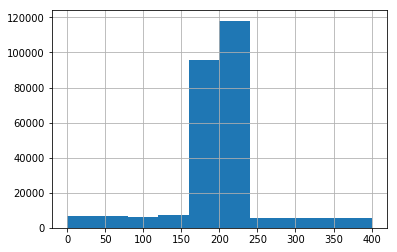

In [6]:
df['vehicle_y'].hist()

In [2]:
def sample(x, y, x0, y0, r):
    return (x-x0)**2+(y-y0)**2 <= r**2;

In [7]:
sensor1 = [];
sensor1.append([406.55, 190.00]);
dis = 200.00
for i in range(1,8):
    sensor1.append([sensor1[i-1][0]+dis, sensor1[i-1][1]]);
sensor2 = [];
sensor2.append([393.45, 210.00]);
for i in range(1,8):
    sensor2.append([sensor2[i-1][0]+dis, sensor2[i-1][1]]);


In [8]:
for i in range(8):
    df1[`i`+"toRight"] = sample(df1['vehicle_x'], df1['vehicle_y'], sensor1[i][0], sensor1[i][1], 10.00).astype(int);
for i in range(8):
    df1[`i`+"toLeft"] = sample(df1['vehicle_x'], df1['vehicle_y'], sensor2[i][0], sensor2[i][1], 10.00).astype(int);

print df1[1:10]

   timestep_time  vehicle_id  vehicle_x  vehicle_y  0toRight  1toRight  \
1              1        1089    1204.95       5.10         0         0   
2              1          59     398.35     384.88         0         0   
3              2        1089    1201.65      15.35         0         0   
4              2         522    1595.05     394.90         0         0   
5              2          59     398.35     373.76         0         0   
6              3        1089    1201.65      25.77         0         0   
7              3         522    1595.05     384.36         0         0   
8              3          59     398.35     362.63         0         0   
9              4        1089    1201.65      36.63         0         0   

   2toRight  3toRight  4toRight  5toRight  6toRight  7toRight  0toLeft  \
1         0         0         0         0         0         0        0   
2         0         0         0         0         0         0        0   
3         0         0         0      

In [9]:
df1.sort_values(by=['vehicle_id', 'timestep_time'], ascending=True)
sd = [];
for i in range(8):
    sd.append(df1.loc[df1[`i`+'toRight'] == 1])
    sd[i] = sd[i][['timestep_time', 'vehicle_id']]
for i in range(8):
    sd.append(df1.loc[df1[`i`+'toLeft'] == 1])
    sd[i] = sd[i][['timestep_time', 'vehicle_id']]

In [106]:
for i in range(16):
    path = '/Users/Murrie_/Desktop/Artery_With_OD/sensor'+ `i`;
    sd[i].to_csv(path_or_buf = path);